In [1]:
import anndata
from scdesigner.simulator import scdesigner
from scdesigner.margins.marginal import NB

I downloaded the data from the scDesign3 [quickstart](https://songdongyuan1994.github.io/scDesign3/docs/articles/scDesign3.html). There are only 100 genes in this demo.

In [ ]:
import os
import requests

save_path = "data/example_sce.h5ad"
if not os.path.exists(save_path):
    response = requests.get("https://go.wisc.edu/69435h")
    with open(save_path, "wb") as f:
        f.write(response.content)

example_sce = anndata.read_h5ad(save_path)
example_sce

The result seems quite sensitive to the learning rate. How can we pick a good default? Maybe we can systematically survey good lr's across a range of public data. Alternatively, is there a good way to adapt during learning?

In [ ]:
import numpy as np

example_sce.X = example_sce.X.toarray().astype(np.float32)
sim = scdesigner(example_sce, NB("~ pseudotime"))
sim

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_gene(sim, example_sce, ix=0):
    # get predictions
    gene = example_sce.var_names[ix]
    y_hat = sim.predict(example_sce.obs)["mu"]
    variance = y_hat + (y_hat ** 2) * sim.predict(example_sce.obs)["alpha"] 

    # build confidence bands
    y_hat["pseudotime"] = example_sce.obs["pseudotime"].values
    y_hat["lower_sd"] = y_hat[gene].values - np.sqrt(variance[gene].values)
    y_hat["upper_sd"] = y_hat[gene].values + np.sqrt(variance[gene].values) 

    # plot
    y_hat = y_hat.sort_values(by="pseudotime")
    sns.scatterplot(x="pseudotime", y=gene, data={"pseudotime": example_sce.obs["pseudotime"], gene: example_sce.X[:, ix]})
    plt.fill_between(y_hat['pseudotime'], y_hat['lower_sd'], y_hat['upper_sd'], color='orange', alpha=0.3)
    sns.scatterplot(x="pseudotime", y=gene, data=y_hat)

for i in range(5):
    plot_gene(sim, example_sce, i)
    plt.show()

In [ ]:
sim = scdesigner(example_sce, NB("~ bs(pseudotime, df=10)"), max_epochs=6)

In [ ]:
for i in range(5):
    plot_gene(sim, example_sce, i)
    plt.show()

In [ ]:
fmla = {"mu": "~ bs(pseudotime, df=10)", "alpha": "~ bs(pseudotime, df=4)"}
sim = scdesigner(example_sce, NB(fmla), max_epochs=6)

In [ ]:
for i in range(5):
    plot_gene(sim, sim.sample(), i)
    plot_gene(sim, example_sce, i)
    plt.show()

In [ ]:
import altair as alt
import pandas as pd

sampled = sim.sample()
X = pd.DataFrame(np.log(1 + sampled.X), columns=sampled.var_names)
#X = pd.DataFrame(np.log(1 + example_sce.X), columns=example_sce.var_names)

sampled_subset = pd.concat([X.iloc[:, :5], sampled.obs], axis=1)
alt.Chart(sampled_subset).mark_circle(opacity=1, size=1).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative')
).properties(width=40, height=40).repeat(
    row=sampled_subset.columns[:5],
    column=sampled_subset.columns[:5]
).configure_axis(labelFontSize=9, titleFontSize=9)

Here is a version of a copula that has a different covariance for each cell type.

In [ ]:
from scdesigner.copula import ScCopula

sim = scdesigner(example_sce, NB(fmla), max_epochs=1, multivariate=ScCopula(formula="~ cell_type"))
print(sim.multivariate.copulas[0].correlation.iloc[:2, :2])
print(sim.multivariate.copulas[1].correlation.iloc[:2, :2]) # different cell types -> different correlations

sim.sample()

# Poisson

In [2]:
from scdesigner.margins.marginal import Poisson

In [3]:
import os
import requests

save_path = "../../data/example_sce.h5ad"
if not os.path.exists(save_path):
    response = requests.get("https://go.wisc.edu/69435h")
    with open(save_path, "wb") as f:
        f.write(response.content)

example_sce = anndata.read_h5ad(save_path)
example_sce

AnnData object with n_obs × n_vars = 2087 × 100
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'cell_type', 'sizeFactor', 'pseudotime'
    var: 'highly_variable_genes'
    uns: 'X_name', 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'PCA', 'UMAP', 'X_pca', 'X_umap'
    layers: 'counts', 'cpm', 'logcounts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
import numpy as np

example_sce.X = example_sce.X.toarray().astype(np.float32)
sim = scdesigner(example_sce, Poisson("~ pseudotime"), max_epochs=10, lr=0.1) # set low learning rate
sim

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/pyl/anaconda3/envs/simulation-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | linear | ModuleDict | 200    | train
----------------------------------------------
200       Trainable params
0         Non-trainable params
200       Total params
0.001     Total estimated model params size (MB)
2         Modules in tra

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


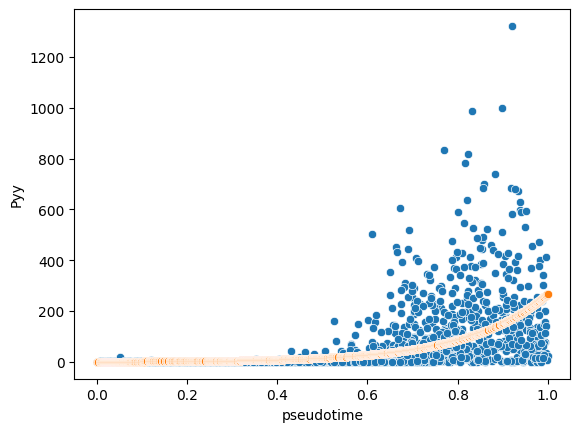

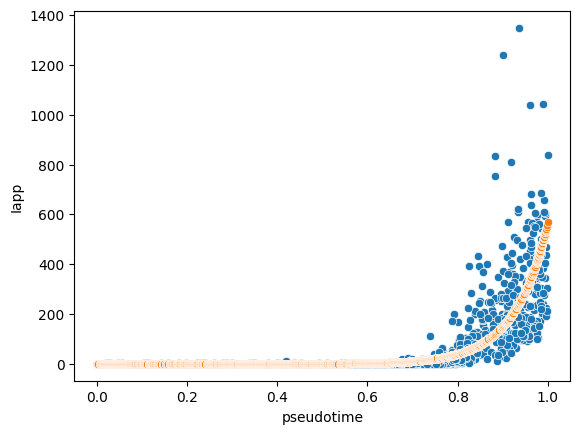

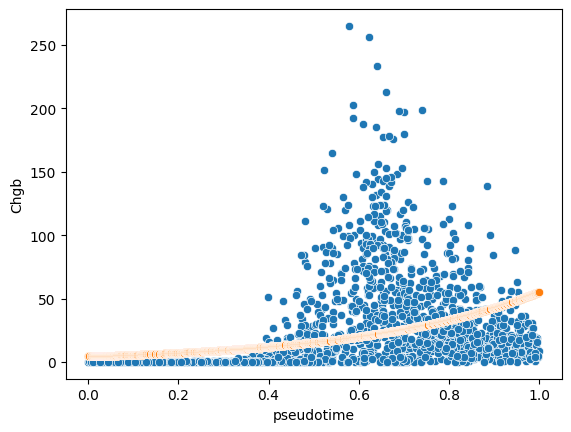

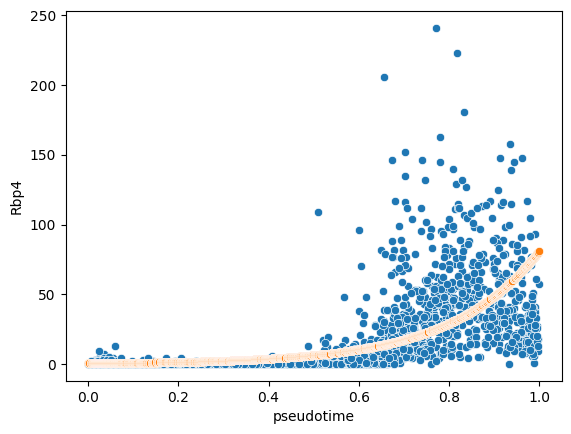

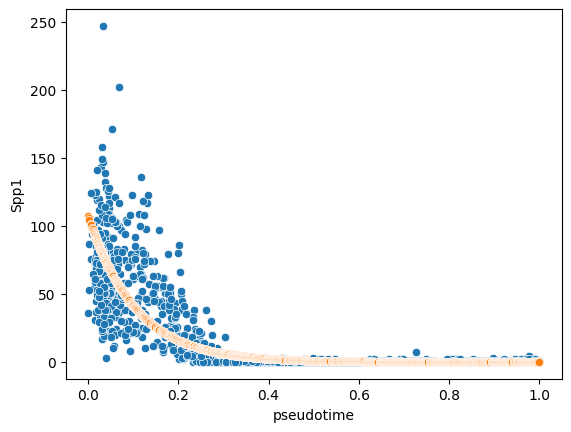

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# plotting mean
def plot_gene(sim, example_sce, ix=0):
    # get predictions
    gene = example_sce.var_names[ix]
    y_hat = sim.predict(example_sce.obs)["mu"]
    y_hat["pseudotime"] = example_sce.obs["pseudotime"].values

    # plot
    y_hat = y_hat.sort_values(by="pseudotime")
    sns.scatterplot(x="pseudotime", y=gene, data={"pseudotime": example_sce.obs["pseudotime"], gene: example_sce.X[:, ix]})
    sns.scatterplot(x="pseudotime", y=gene, data=y_hat)

for i in range(5):
    plot_gene(sim, example_sce, i)
    plt.show()

In [6]:
import altair as alt
import pandas as pd

# plotting correlation of simulated data
sampled = sim.sample()
X = pd.DataFrame(np.log(1 + sampled.X), columns=sampled.var_names)
#X = pd.DataFrame(np.log(1 + example_sce.X), columns=example_sce.var_names)

sampled_subset = pd.concat([X.iloc[:, :5], sampled.obs], axis=1)
alt.Chart(sampled_subset).mark_circle(opacity=1, size=1).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative')
).properties(width=40, height=40).repeat(
    row=sampled_subset.columns[:5],
    column=sampled_subset.columns[:5]
).configure_axis(labelFontSize=9, titleFontSize=9)

AttributeError: 'NoneType' object has no attribute 'numpy'

# Bernoulli

In [7]:
from scdesigner.margins.marginal import Bernoulli

In [11]:
# would need to download this data first
save_path = "../../data/multiomic_methylation.h5ad"
multi = anndata.read_h5ad(save_path)
multi.X

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [12]:
import numpy as np

# multi.X = multi.X.toarray().astype(np.float32)
sim = scdesigner(multi, Bernoulli("~ bs(X1, df=3)"), max_epochs=10)
sim

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | linear | ModuleDict | 108    | train
----------------------------------------------
108       Trainable params
0         Non-trainable params
108       Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/Users/pyl/anaconda3/envs/simulation-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/pyl/anaconda3/envs/simulation-env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval 

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


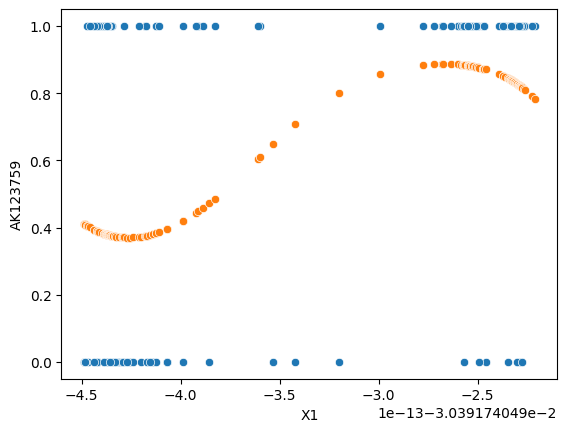

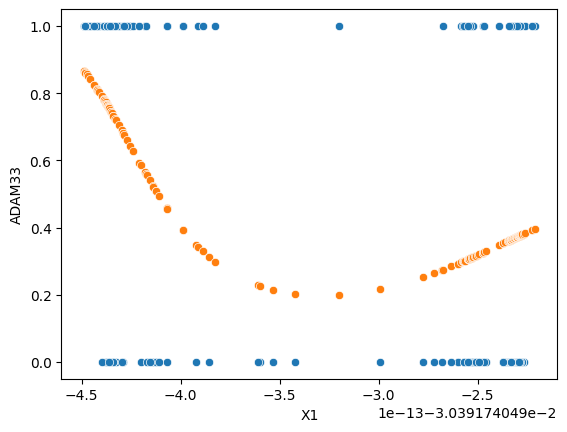

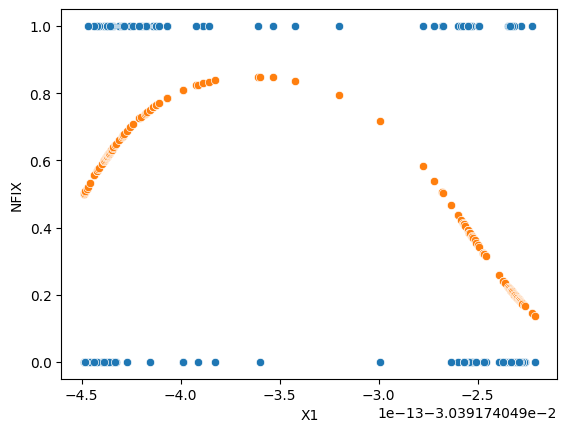

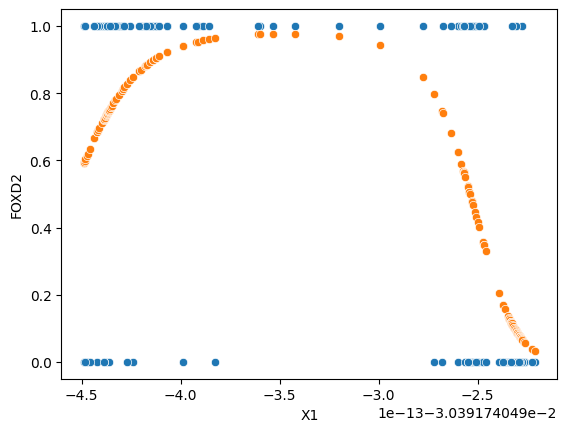

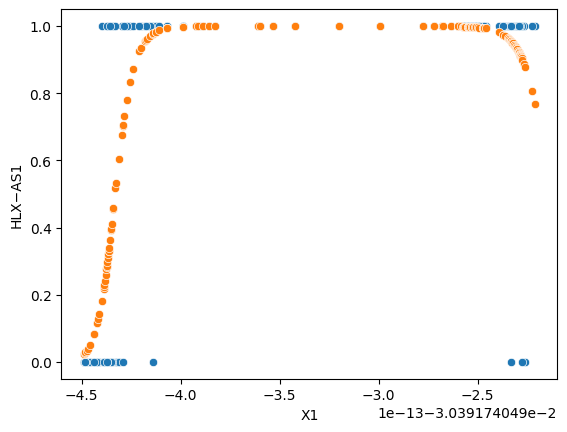

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

# plots predicted p
def plot_gene(sim, example_sce, ix=0, var="pseudotime"):
    # get predictions
    gene = example_sce.var_names[ix]
    mu = sim.predict(example_sce.obs)["mu"] # returns logit of p
    col_name = mu.columns
    y_hat = 1-1 / (1+torch.exp(torch.Tensor(mu.values))) # convert to p
    y_hat = pd.DataFrame(y_hat.numpy(), columns=col_name)
    y_hat[var] = example_sce.obs[var].values

    # plot
    y_hat = y_hat.sort_values(by=var)
    sns.scatterplot(x=var, y=gene, data={var: example_sce.obs[var], gene: example_sce.X[:, ix]})
    sns.scatterplot(x=var, y=gene, data=y_hat)

for i in range(5):
    plot_gene(sim, multi, i, "X1")
    plt.show()

In [ ]:

# compare real vs simulated data
def plot_gene(sim, example_sce, ix=0, var="pseudotime"):
    # get predictions
    gene = example_sce.var_names[ix]
    sampled = sim.sample()

    jitter_real = example_sce.X + np.random.normal(0,0.1,example_sce.X.shape)
    jitter_sim = sampled.X + np.random.normal(0,0.1,sampled.X.shape)
    
    # plot
    sns.scatterplot(x=var, y=gene, data={var: example_sce.obs[var], gene: jitter_real[:, ix]})
    sns.scatterplot(x=var, y=gene, data={var: example_sce.obs[var], gene: jitter_sim[:, ix]})

for i in range(5):
    plot_gene(sim, multi, i, "X1")
    plt.show()
